In [1]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the netCDR for basalt
# vs optimizing aglime case
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "low"
idx_1 = "002" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_1 = "basev1" # "basev3_multiCTRL"

# FERT LEVEL 2
fertLevel_2 = "hi"
idx_2 = "002" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_2 = "basev1"   # "basev3_multiCTRL"

In [2]:
# ---- READ IN DATA
# FERT LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))
# # read in profile data
# dssil1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
# dscc1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
# dssil1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
# dscc1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

# FERT LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))
# # read in profile data
# dssil2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
# dscc2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
# dssil2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
# dscc2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

FileNotFoundError: [Errno 2] No such file or directory: '/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate/meanAnn_shortRun_lowFert_basev1_002/ds_sil.nc'

# Plot 1:
netCDR contour plot for basalt and aglime for two fertilizer cases

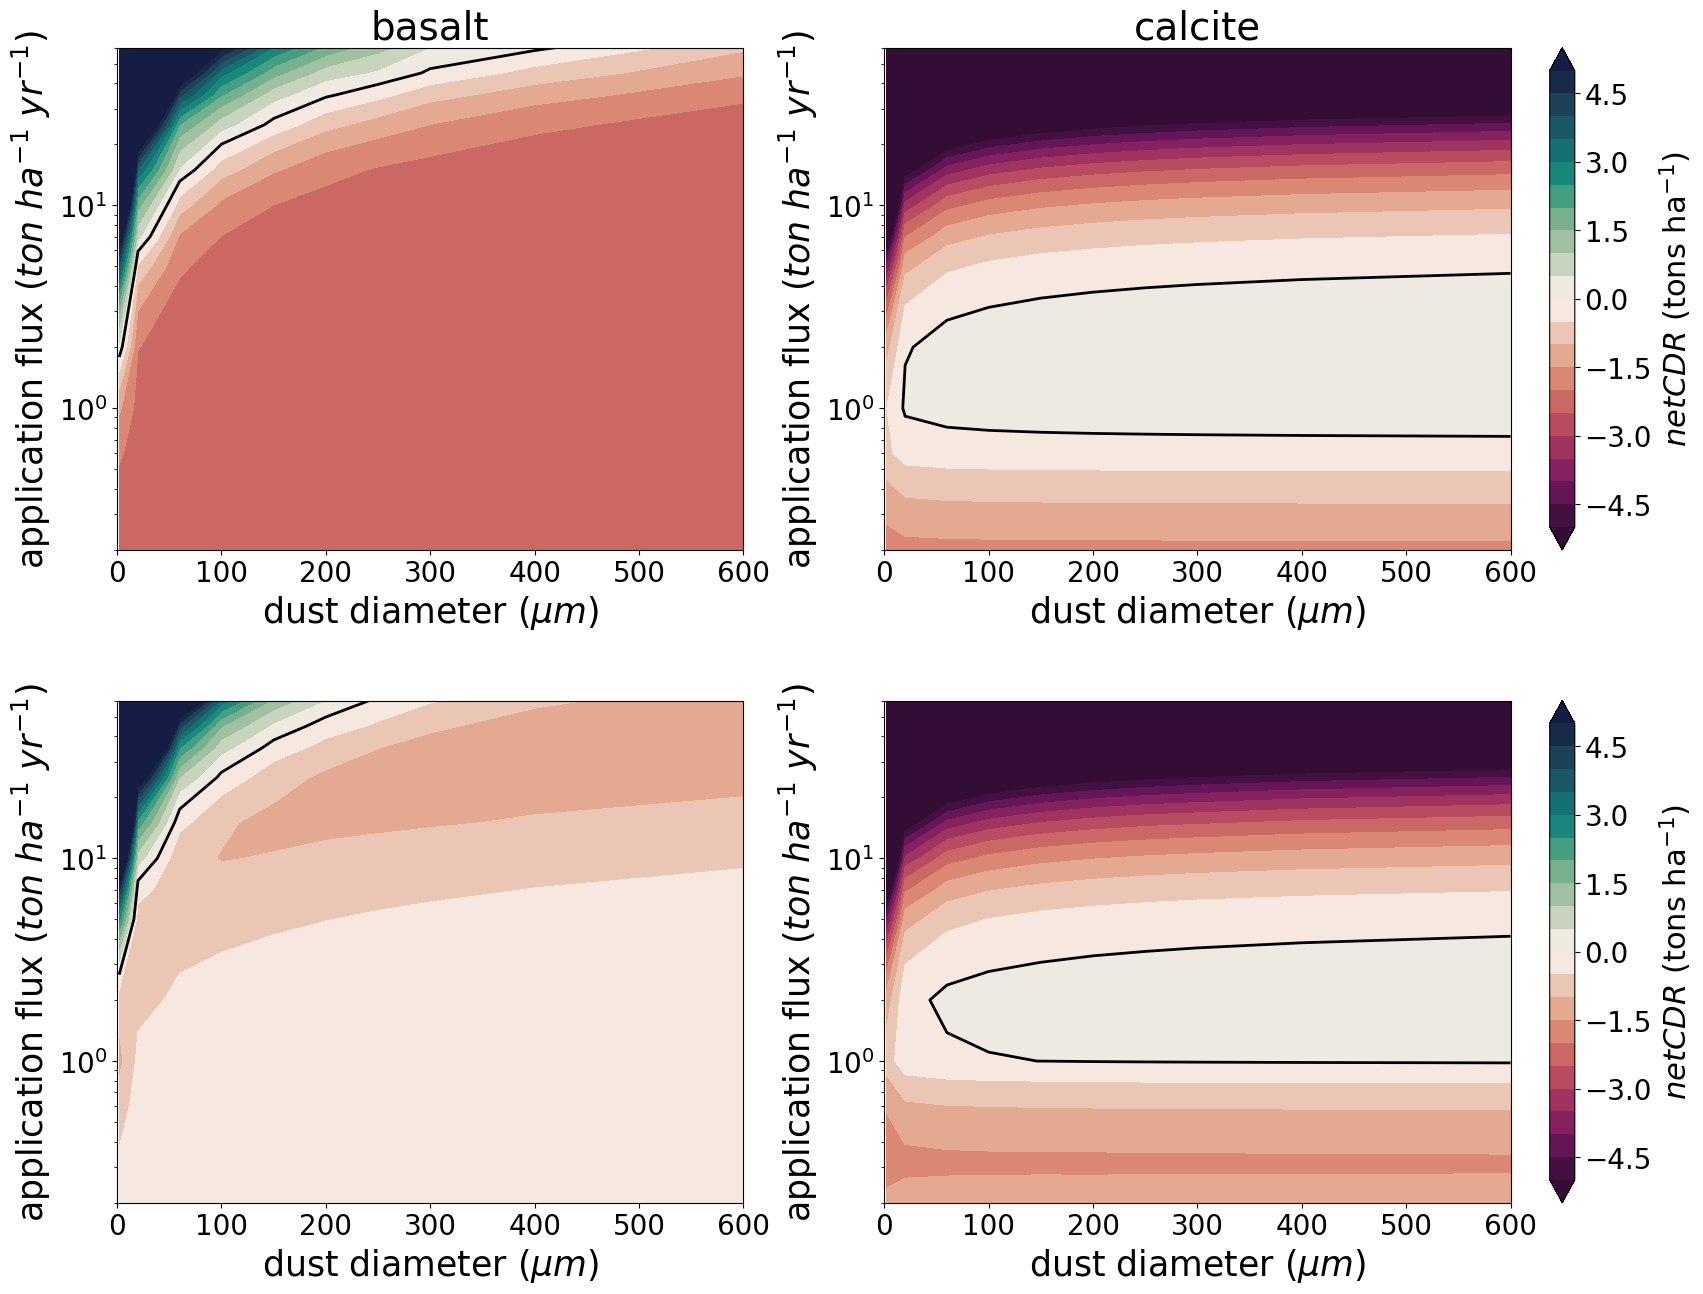

In [12]:
# --- PLOT --------------------
# set data conditions
fsname_sil, fsname_cc = 'gbas', 'cc'
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'conservative'
logX = False
logY = True

# pull out the data we want
dsanom_sil1 = ds_anom1.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom_cc1 = ds_anom1.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
tfert1 =fertLevel_1

dsanom_sil2 = ds_anom2.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom_cc2 = ds_anom2.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
tfert2 =fertLevel_2

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom_sil1 = dsanom_sil1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_cc1 = dsanom_cc1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_sil2 = dsanom_sil2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_cc2 = dsanom_cc2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60 
# *****************************

# x and y arrays
# [sil fs]
x1 = dsanom_sil['dustrad'].values
y1 = dsanom_sil['dustrate_ton_ha_yr'].values
# [cc fs]
x2 = dsanom_cc['dustrad'].values
y2 = dsanom_cc['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1 
# [silicate]
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom_sil1.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom_sil1.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt and netCDR aglime; {tfert}Fert\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"basalt", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# [calcite]
ax = plt.subplot(spec[1])
contour = plt.contourf(x1*2,y1,dsanom_cc1.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom_cc1.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt and netCDR aglime; {tfert}Fert\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"calcite", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)

# --- fertlevel 2
# [silicate]
ax = plt.subplot(spec[2])
contour = plt.contourf(x1*2,y1,dsanom_sil2.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom_sil2.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt and netCDR aglime; {tfert}Fert\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fsname_sil} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# [calcite]
ax = plt.subplot(spec[3])
contour = plt.contourf(x2*2,y2,dsanom_cc2.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom_cc2.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"\n{fsname_cc} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


In [ ]:
# -------------